## Common Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json, os, gzip
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_moons, make_circles, make_blobs

Constants

In [13]:
FIGURE_SAVE_PATH: str = "./figures"
TABLE_SAVE_PATH: str = "./table_results"
DATASET_PATH: str = "./datasets"
FILES:list[str] = ["dblp-ref-0.json", "dblp-ref-1.json", "dblp-ref-2.json", "dblp-ref-3.json"]

# Sampling length our dataset is too big this makes it more manageable to work with
DEV_MODE:bool = True
SAMPLES_PER_YEAR:int = 250 if DEV_MODE else 2000

### Load the Dataset

In [3]:
# loading data
def read_json_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            yield json.loads(line)

def load_all(files=FILES):
    rows = []
    for fp in files:
        for rec in read_json_lines(f"./datasets/{fp}"):
            rows.append(rec)
    return pd.DataFrame(rows)

df = load_all()

as_type = {
    "year": "category",
    "n_citation": np.uint32,
}

df = df.astype(as_type)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3079007 entries, 0 to 3079006
Data columns (total 8 columns):
 #   Column      Dtype   
---  ------      -----   
 0   abstract    object  
 1   authors     object  
 2   n_citation  uint32  
 3   references  object  
 4   title       object  
 5   venue       object  
 6   year        category
 7   id          object  
dtypes: category(1), object(6), uint32(1)
memory usage: 155.6+ MB


In [115]:
df.head(10)

,abstract,authors,n_citation,references,title,venue,year,id
0,The purpose of this study is to develop a lear...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",0,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013,00127ee2-cb05-48ce-bc49-9de556b93346
1,This paper describes the design and implementa...,"[Gareth Beale, Graeme Earl]",50,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,visual analytics science and technology,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,This article applied GARCH model instead AR or...,"[Altaf Hossain, Faisal Zaman, Mohammed Nasser,...",50,"[2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...","Comparison of GARCH, Neural Network and Suppor...",pattern recognition and machine intelligence,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,NaN,"[Jea-Bum Park, Byungmok Kim, Jian Shen, Sun-Yo...",0,"[8c78e4b0-632b-4293-b491-85b1976675e6, 9cdc54f...",Development of Remote Monitoring and Control D...,,2011,00338203-9eb3-40c5-9f31-cbac73a519ec
4,NaN,"[Giovanna Guerrini, Isabella Merlo]",2,NaN,Reasonig about Set-Oriented Methods in Object ...,,1998,0040b022-1472-4f70-a753-74832df65266
5,NaN,"[Rafael Álvarez, Leandro Tortosa, José-Francis...",0,NaN,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,international conference on computer graphics ...,2009,005ce28f-ed77-4e97-afdc-a296137186a1
6,NaN,"[Jovan Dj. Golic, Guglielmo Morgari]",2,NaN,Vectorial fast correlation attacks.,,2004,00638a94-23bf-4fa6-b5ce-40d799c65da7
7,NaN,"[Guzin Ulutas, Mustafa Ulutas, Vasif V. Nabiyev]",0,"[5626736c-e434-4e2d-8405-54940fab88ab, 8e87e87...",Improved Secret Image Sharing Method By Encodi...,international symposium on computer and inform...,2011,00701b05-684f-45f9-b281-425abfec482c
8,NaN,"[Pranay Chaudhuri, Hussein Thompson]",0,NaN,A Self-Stabilizing Algorithm for Finding the C...,parallel and distributed processing techniques...,2003,00745041-3636-4d18-bbec-783c4278c40d
9,NaN,"[Dominik Szajerman, Adam Jurczyński]",0,"[3fcd7cdc-20e6-4ea3-a41c-db126fcc5cfe, bf3a11c...",Fur Visualisation for Computer Game Engines an...,international conference on computer vision an...,2014,00964544-cbe2-4da9-bb5a-03333160eb34


### Task 1: Preprocessing & Feature Generation

#### Preprocess & Sample The Dataset

In [4]:
# Drop Missing years
df = df[(df["title"].notna()) & (df["year"].notna())]


# Filter out rare venues
venue_counts = df["venue"].value_counts()
df = df[df["venue"].isin(venue_counts[venue_counts >= 50].index)]

# Filter out missing venues
print(len(df[df['venue'].str.strip() == ""]))
df = df[df['venue'].str.strip() != ""]

# as we saw later when doing simple EDA the papers with n_citation = 50 are likely a data scraping error as it shift the distribution outside a power like distribution
# SEE:
# https://link.springer.com/article/10.1007/s100510050359
df_clean_source = df[df['n_citation'] != 50]


print(f"Sampling {SAMPLES_PER_YEAR} papers per year...")

sampled_df = (
    df_clean_source.groupby('year', observed = True)
    .apply(lambda x : x.sample(min(len(x), SAMPLES_PER_YEAR)), include_groups = False)
    .reset_index(level = 'year')
)

# Handle normalizing or fixing the dataset on the sample since it will be less
# computationally expensive

# Replace missing abstracts with empty string
sampled_df["abstract"] = sampled_df["abstract"].fillna("")

# Normalize Text
sampled_df["title"] = sampled_df["title"].str.lower()
sampled_df["abstract"] = sampled_df["abstract"].str.lower()

# Combine title and abstract as one feature
sampled_df['text'] = sampled_df['title'] + " " + sampled_df['abstract']

# Reset Index so df rows align with matrix rows (0 to N)
sampled_df = sampled_df.reset_index(drop = True)

print(f"Original Shape: {df.shape}")
print(f"Sampled Shape: {sampled_df.shape}")
sampled_df.head()


506699
Sampling 250 papers per year...
Original Shape: (2556505, 8)
Sampled Shape: (14852, 9)


,year,abstract,authors,n_citation,references,title,venue,id,text
0,1936,,[J. Barkley Rosser],1,NaN,constructibility as a criterion for existence,Journal of Symbolic Logic,8581f824-2333-4b5f-b277-a4020281a7f8,constructibility as a criterion for existence
1,1936,,[Emil L. Post],367,[],finite combinatory processes--formulation 1,Journal of Symbolic Logic,e254cbb5-e369-49dc-97a2-4d60eaea27dd,finite combinatory processes--formulation 1
2,1936,,[Alonzo Church],150,[c45bdb20-3d36-4d7d-8a83-203e3d3bff9e],correction to a note on the entscheidungsproblem,Journal of Symbolic Logic,c5c32b04-0a67-4cd6-b135-3f65ab87e33b,correction to a note on the entscheidungsproblem
3,1936,,[Alonzo Church],949,[],a note on the entscheidungsproblem,Journal of Symbolic Logic,c45bdb20-3d36-4d7d-8a83-203e3d3bff9e,a note on the entscheidungsproblem
4,1936,,[W. V. Quine],19,NaN,toward a calculus of concepts,Journal of Symbolic Logic,566fc941-6ba6-41ab-b579-ad3d7fe4ca27,toward a calculus of concepts


#### Generate Black Box Features
These are for our clustering and classification tasks in our proposal.

In [5]:
# TF-IDF + PCA Feature Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Run TF-IDF and PCA
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1,2)
)
X_tfidf = tfidf.fit_transform(sampled_df["text"])

pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Create a df from PCA results and attach it to sampled_df
pca_cols = [f"pca_{i}" for i in range(100)]
pca_df = pd.DataFrame(X_pca, columns=pca_cols)
sampled_df = pd.concat([sampled_df, pca_df], axis=1)

# Author and Venue Embeddings
# Venue embeddings
venue_emb = sampled_df.groupby("venue")[pca_cols].mean()

# Author embeddings
authors_exploded = sampled_df.explode('authors')
author_emb = authors_exploded.groupby('authors')[pca_cols].mean()

#### Generate Interpretable Features
These are the metadata features for trend analysis and network analysis

In [7]:
# Number of Authors (Collaboration Size)
sampled_df['num_authors'] = sampled_df['authors'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Title Length (Character Count)
sampled_df['title_length'] = sampled_df['title'].apply(lambda x: len(str(x)))

# Number of References (How many papers this paper cites)
sampled_df['num_refs'] = sampled_df['references'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Citation Velocity (Citations per year)
sampled_df['citation_velocity'] = sampled_df['n_citation'] / (2018 - sampled_df['year'].astype(int) + 1)
print(sampled_df['citation_velocity'].max())

# Change the types as well to reduce memory
as_type = {
    "num_authors": "category",
    "title_length": np.uint16,
    "num_refs": np.uint8,
    "citation_velocity": np.float32,
}

sampled_df[["title", 'year', 'num_authors', 'num_refs', 'citation_velocity']].head()


790.3076923076923


,title,year,num_authors,num_refs,citation_velocity
0,constructibility as a criterion for existence,1936,1,0,0.012048
1,finite combinatory processes--formulation 1,1936,1,0,4.421687
2,correction to a note on the entscheidungsproblem,1936,1,1,1.807229
3,a note on the entscheidungsproblem,1936,1,0,11.433735
4,toward a calculus of concepts,1936,1,0,0.228916


#### EDA

To see if our preprocessing pipeline generated quality data

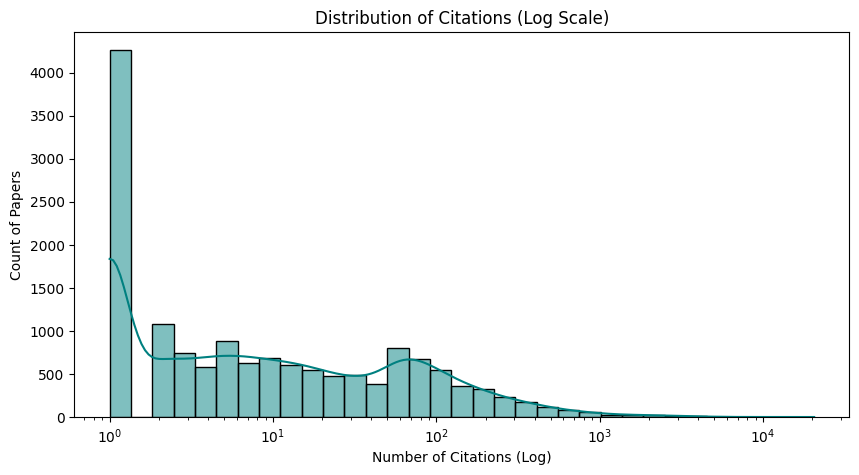

/tmp/ipykernel_5394/3985746004.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  auth_trend = sampled_df.groupby('year')['num_authors'].mean().reset_index()


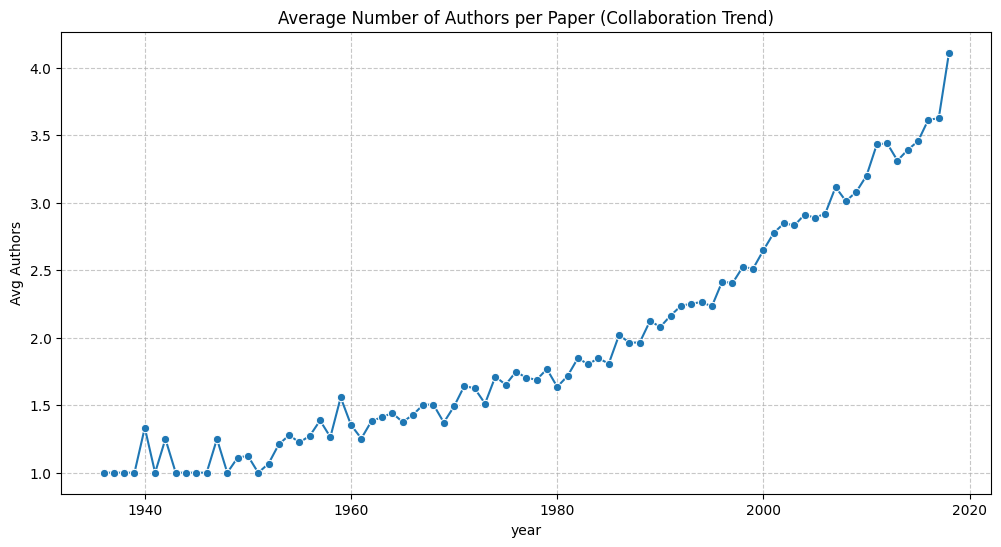

/tmp/ipykernel_5394/3985746004.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='venue', data=sampled_df[sampled_df['venue'].isin(top_venues)], order=top_venues, palette='viridis')


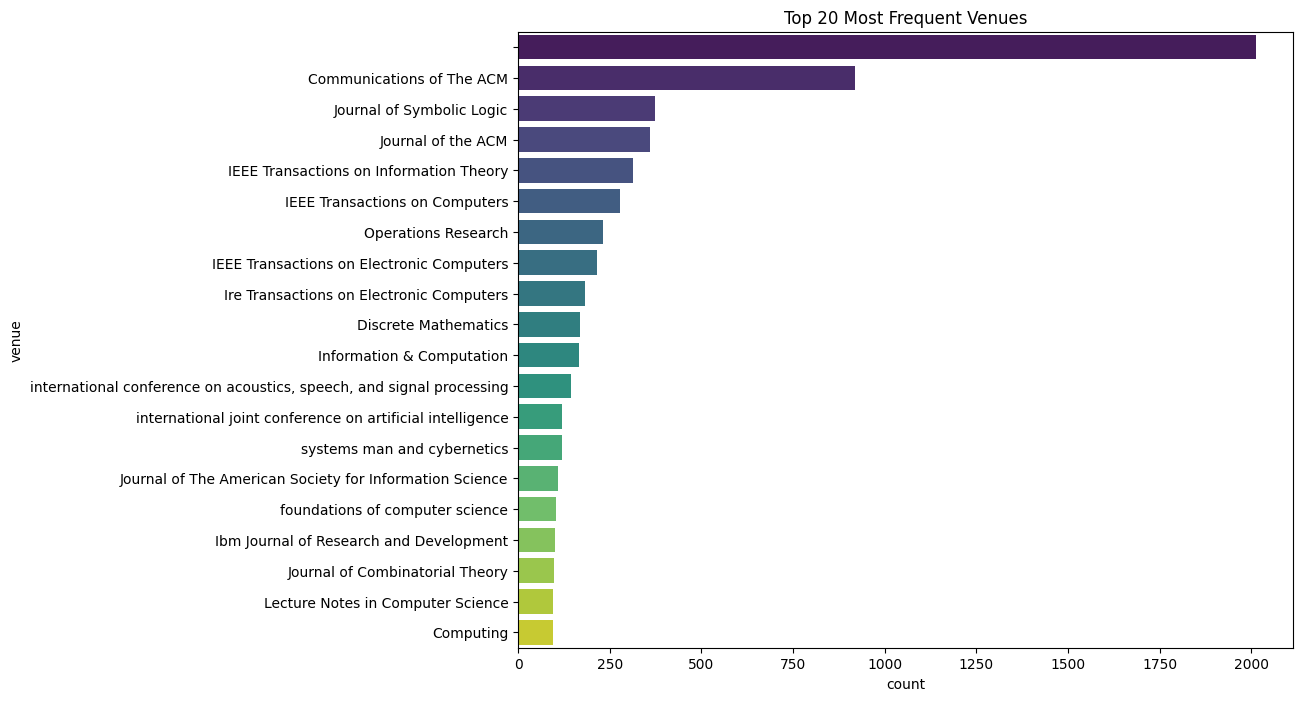

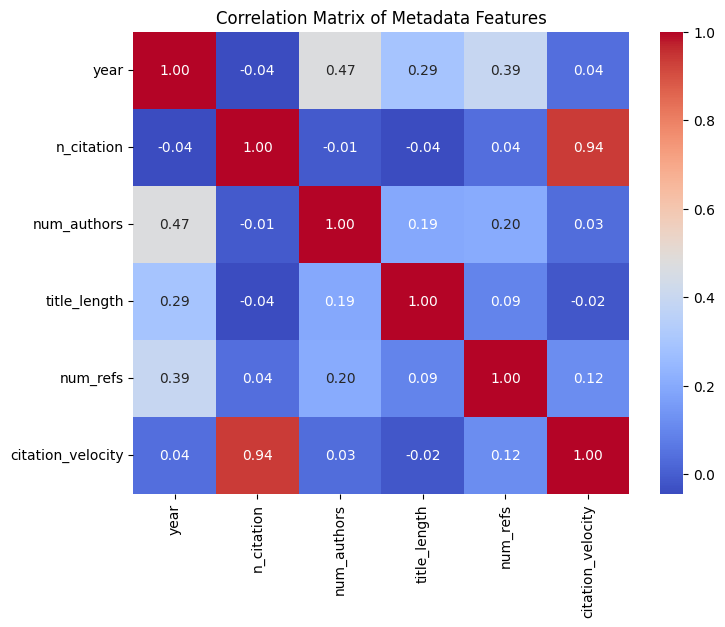

                       year  n_citation  num_authors  title_length  num_refs  \
year               1.000000   -0.044491     0.471459      0.293793  0.394703   
n_citation        -0.044491    1.000000    -0.011587     -0.043321  0.041050   
num_authors        0.471459   -0.011587     1.000000      0.192384  0.201519   
title_length       0.293793   -0.043321     0.192384      1.000000  0.090165   
num_refs           0.394703    0.041050     0.201519      0.090165  1.000000   
citation_velocity  0.037375    0.935986     0.033410     -0.018369  0.117820   

                   citation_velocity  
year                        0.037375  
n_citation                  0.935986  
num_authors                 0.033410  
title_length               -0.018369  
num_refs                    0.117820  
citation_velocity           1.000000  


In [15]:
# The "Power Law" Check (Citation Distribution)
# See https://link.springer.com/article/10.1007/s100510050359
# This is now done above in the preprocessing check
# Preprocessed above to remove n_citation = 50 outlier
# ARTIFACT_VAL = 50
# clean_df = sampled_df[sampled_df['n_citation'] != ARTIFACT_VAL]

plt.figure(figsize=(10,5))
sns.histplot(sampled_df['n_citation'] + 1, log_scale=True, kde=True, color='teal')
plt.title('Distribution of Citations (Log Scale)')
plt.xlabel('Number of Citations (Log)')
plt.ylabel('Count of Papers')
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_citation_distribution.png")
plt.show()

plt.figure(figsize=(12, 6))
# Group by year and get mean authors
auth_trend = sampled_df.groupby('year')['num_authors'].mean().reset_index()
sns.lineplot(data=auth_trend, x='year', y='num_authors', marker='o')
plt.title('Average Number of Authors per Paper (Collaboration Trend)')
plt.ylabel('Avg Authors')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_collaboration_trend.png")
plt.show()

plt.figure(figsize=(10, 8))
# Get top 20 venues
top_venues = sampled_df['venue'].value_counts().nlargest(20).index
# Filter data to only those venues for plotting
sns.countplot(y='venue', data=sampled_df[sampled_df['venue'].isin(top_venues)], order=top_venues, palette='viridis')
plt.title('Top 20 Most Frequent Venues')
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_top_venues.png")
plt.show()



# Select only numeric metadata
meta_cols = ['year', 'n_citation', 'num_authors', 'title_length', 'num_refs', 'citation_velocity']

plt.figure(figsize=(8, 6))
sns.heatmap(sampled_df[meta_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Metadata Features')
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_corr_matrix.png")
plt.show()

print(sampled_df[meta_cols].corr())

In [10]:
print(sampled_df[['year','n_citation','num_authors','title_length','num_refs','citation_velocity']].corr()
)

                       year  n_citation  num_authors  title_length  num_refs  \
year               1.000000   -0.044491     0.471459      0.293793  0.394703   
n_citation        -0.044491    1.000000    -0.011587     -0.043321  0.041050   
num_authors        0.471459   -0.011587     1.000000      0.192384  0.201519   
title_length       0.293793   -0.043321     0.192384      1.000000  0.090165   
num_refs           0.394703    0.041050     0.201519      0.090165  1.000000   
citation_velocity  0.037375    0.935986     0.033410     -0.018369  0.117820   

                   citation_velocity  
year                        0.037375  
n_citation                  0.935986  
num_authors                 0.033410  
title_length               -0.018369  
num_refs                    0.117820  
citation_velocity           1.000000  


### 4. Topic Clustering

### 5. Temporal Trend Analysis

In [ ]:
# drop missing values
df = df.dropna(subset=['title', 'year', 'authors', 'references'])

# fill missing 
df['venue'] = df['venue'].fillna('Unknown Venue')
df['abstract'] = df['abstract'].fillna("")

# make sure year is integer
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df[df['year'].between(1950, 2017)]

In [ ]:
# create numerical features for clustering
df["text"] = (df["title"].fillna("") + " " + df["abstract"].fillna("")).str.lower()

# vectorize text using hashing
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=50000, stop_words="english", alternate_sign=False)
X_hv = hv.fit_transform(df["text"])

# dimensionality reduction using TruncatedSVD
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=150, random_state=42)
X_svd = svd.fit_transform(X_hv)
X_svd = Normalizer(copy=False).fit_transform(X_svd)

# clustering using KMeans
K = 50
kmeans = MiniBatchKMeans(n_clusters=K, random_state=42, batch_size=1024)
labels = kmeans.fit_predict(X_svd)
df['cluster'] = labels

In [ ]:
# temporal trend analysis 
trend = df.groupby(['year', 'cluster']).size().rename('count').reset_index()

year_totals = trend.groupby('year')['count'].sum().rename('year_total')
trend = trend.merge(year_totals, on='year')
trend["share"] = trend["count"] / trend["year_total"]

# visualization of trends
sns.set(style="whitegrid", context="talk", palette="muted")
top_clusters = df["cluster"].value_counts().head(10).index
trend_top = trend[trend["cluster"].isin(top_clusters)]

plt.figure(figsize=(14, 8))
for cluster in top_clusters:
    sub = trend_top[trend_top["cluster"] == cluster].sort_values("year")
    plt.plot(sub["year"], sub["share"], label=f"Cluster {cluster}", linewidth=2)

plt.axvline(2010, color="k", linestyle="--", alpha=0.5)
plt.title("Temporal Trends of Top 10 Clusters in Publications")
plt.xlabel("Year")
plt.ylabel("Share of Publications")
plt.legend(loc="upper left", ncol=2, fontsize=10, frameon=True)
plt.show()

In [ ]:
# annotate fastest rising clusters post-2010
from sklearn.linear_model import LinearRegression

def cluster_slope(cluster_id):
    sub = trend[trend["cluster"] == cluster_id]
    X = sub["year"].values.reshape(-1,1)
    y = sub["share"].values
    if len(sub) < 5:
        return np.nan
    return LinearRegression().fit(X,y).coef_[0]

slopes = {c: cluster_slope(c) for c in top_clusters}
fast_risers = sorted(slopes, key=slopes.get, reverse=True)[:3]

plt.figure(figsize=(14,8))
for c in top_clusters:
    sub = trend_top[trend_top["cluster"] == c].sort_values("year")
    plt.plot(sub["year"], sub["share"], label=f"Cluster {c}", linewidth=2)

plt.axvline(2010, color="k", linestyle="--", alpha=0.5)

for c in fast_risers:
    sub = trend_top[trend_top["cluster"] == c].sort_values("year")
    if not sub.empty:
        x, y = sub["year"].iloc[-1], sub["share"].iloc[-1]
        plt.annotate(
            f"↑ Cluster {c}",
            xy=(x,y),
            xytext=(x+1,y+0.01),
            arrowprops=dict(arrowstyle="->", color="gray")
        )

plt.title("Topic trends with post-2010 marker and fast risers")
plt.xlabel("Year")
plt.ylabel("Share of papers")
plt.legend(loc="upper left", ncol=2, fontsize=10, frameon=True)
plt.tight_layout()
plt.show()


### 6. Predictive Modeling

### 7. Network Analysis